This training run is done on the new dataset with 1830 airfoils, 1 mach #, 25 AoA #s, and 3 Re #s.

It runs on a very deep MLP.

In [1]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

In [2]:
# Import all the models, training functions, manipulators here

# Define the relative paths, append it to the system path
import sys
from pathlib import Path
project_root = Path.cwd().resolve().parents[3]
github_root = Path.cwd().resolve().parents[2]
sys.path.append(str(project_root))
sys.path.append(str(github_root))

print(project_root)
print(github_root)

# Import shenanigans
from defs.helper_functions.training_functions import *
from defs.helper_functions.data_loaders import *
from defs.models.MLP import *

# Time, to precisely: time
import time

C:\SenkDosya\Projects\AeroML
C:\SenkDosya\Projects\AeroML\initial-project


In [3]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Figure out the data
df = pd.read_csv(rf"{str(project_root)}\airfoil_data\airfoil_dataset_8bern.csv")

df = df.drop(['N1', 'N2'], axis=1) # Remove N1 and N2 since all the airfoils are subsonic

df['Reynolds'] = df['Reynolds'] / 1000000 # Normalize the Reynolds feature, too dominant

print(df.head)

geom, cond, perf, names= get_dataset(df, loc_geometry=[1,20], loc_cond=[21,23], loc_perf_coeffs=[24,26], loc_names=0) # Get the necessary stuff for the dataset
print(df.shape); print(geom.shape); print(cond.shape); print(perf.shape); print(len(names))

ds = AirfoilDataset(geom, cond, perf, names)

del df, geom, cond, perf, names # Delete these to preserve memory

cfg_loader = {
    'n_epoch': 100,
    'n_train': 1000,
    'n_test': 17250,
    'train_batch': 1
}

dl_train, dl_val, dl_test = get_dataloaders(ds=ds, cfg_loader=cfg_loader)


<bound method NDFrame.head of         airfoil_name      Bu_0      Bu_1      Bu_2      Bu_3      Bu_4  \
0       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
1       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
2       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
3       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
4       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
...              ...       ...       ...       ...       ...       ...   
137245  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137246  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137247  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137248  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137249  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   

            Bu_5      Bu_6      Bu_7     Bu_8  ...      Bl_7      Bl_8  \
0      

In [6]:
import torch.nn as nn

# Define the model and optimizer

cfg_mlp = {
    'input_dim': 23,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048],
    'shape_activation': nn.Tanh
}

model = MLP(cfg_mlp=cfg_mlp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

model = model.to(device)

# Define the loss_fn

loss_fn = nn.MSELoss()

In [13]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor_1 = torch.randn(5, 20).to(device)
show_tensor_2 = torch.randn(5, 3).to(device)

# Forward pass
output = model(show_tensor_1, show_tensor_2)

make_dot(output, params=dict(model.named_parameters())).render("model_graph_mlp", format="png")

from defs.helper_functions.auxiliary import *



print(f'MLP Model Parameters: {get_n_params(model=model)}')

from defs.models.NIF import *

cfg_shape_net = {
    'input_dim': 20,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048],
    'shape_activation': nn.SELU
}

cfg_param_net = {
    'input_dim': 3,
    'hidden_units': [512,512,512],
    'param_activation': nn.Tanh
}

model_NIF = NIF_Pointwise(cfg_shape_net=cfg_shape_net, cfg_param_net=cfg_param_net)

print(f'For Reference, PairNIF Model Parameters: {get_n_params(model=model_NIF)}')

MLP Model Parameters: 16840707
For Reference, PairNIF Model Parameters: 22616582


In [9]:
# Train the model

# Define the configs of train
cfg_train = {
    'cfg_loader': cfg_loader,
    'dtype': torch.float32,
    'device': device
}

dataloaders = [dl_train, dl_val, dl_test]


collector_dict, model = train(cfg_train=cfg_train, model=model, optimizer=optimizer, loss_fn=loss_fn, dataloaders=dataloaders)

Epoch 1 | Train run 1 loss: 0.9231239557266235
Epoch 1 | Train run 2 loss: 0.09283596277236938
Epoch 1 | Train run 3 loss: 0.3740715980529785
Epoch 1 | Train run 4 loss: 0.024000447243452072
Epoch 1 | Train run 5 loss: 0.024051038548350334
Epoch 1 | Train run 6 loss: 0.02362535148859024
Epoch 1 | Train run 7 loss: 0.4350975751876831
Epoch 1 | Train run 8 loss: 0.014563772827386856
Epoch 1 | Train run 9 loss: 0.1632288098335266
Epoch 1 | Train run 10 loss: 0.13900411128997803
Epoch 1 | Train run 11 loss: 0.00045363581739366055
Epoch 1 | Train run 12 loss: 0.04119165241718292
Epoch 1 | Train run 13 loss: 0.08153994381427765
Epoch 1 | Train run 14 loss: 0.020776521414518356
Epoch 1 | Train run 15 loss: 0.02513241581618786
Epoch 1 | Train run 16 loss: 0.0704464465379715
Epoch 1 | Train run 17 loss: 0.3578054904937744
Epoch 1 | Train run 18 loss: 0.014713771641254425
Epoch 1 | Train run 19 loss: 0.13390608131885529
Epoch 1 | Train run 20 loss: 0.06482291221618652
Epoch 1 | Train run 21 loss

torch.Size([100000])
100000


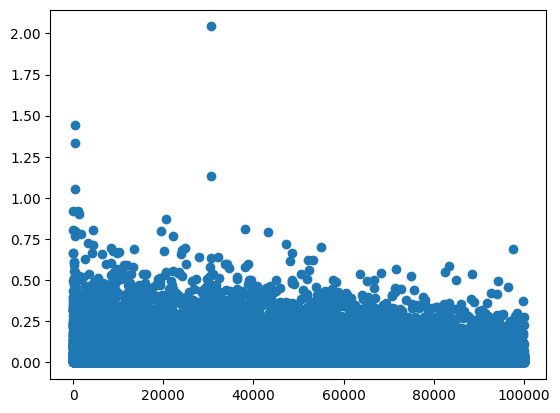

In [10]:
print(collector_dict['losses']['train'].shape)
import numpy as np


train_losses = collector_dict['losses']['train'].numpy()
index= np.arange(100000)

print(train_losses.size)

import matplotlib.pyplot as plt

plt.scatter(index, train_losses, )
plt.show()

[0.04592744 0.04050958 0.04247992 0.03294811 0.04872202 0.03285091
 0.04508909 0.04747866 0.04642572 0.03318253 0.04077138 0.03782475
 0.03455456 0.03071873 0.01968212 0.05412256 0.03133031 0.03195502
 0.04051251 0.03968008 0.06107992 0.03985832 0.02959938 0.0302616
 0.03728683 0.02016002 0.02662169 0.02696011 0.02643129 0.04999102
 0.03008514 0.02627503 0.03077819 0.03067024 0.02650946 0.02410593
 0.03670377 0.03150482 0.04682709 0.04603367 0.01839416 0.05028099
 0.02449973 0.0254914  0.03332103 0.02722812 0.02384411 0.0283518
 0.02568361 0.03543225 0.0385117  0.03039552 0.01723555 0.0321877
 0.03865474 0.02024494 0.02599558 0.02709573 0.02720159 0.02077164
 0.02101278 0.02602069 0.02188451 0.01614622 0.01992373 0.02017236
 0.02272286 0.01795361 0.0150795  0.02254415 0.01942897 0.03130555
 0.01789476 0.0168744  0.01445534 0.01700667 0.02144799 0.0227451
 0.01898583 0.08439499 0.03249904 0.01767494 0.01957297 0.01280113
 0.02436884 0.04277363 0.02688076 0.02391016 0.02558991 0.01710257

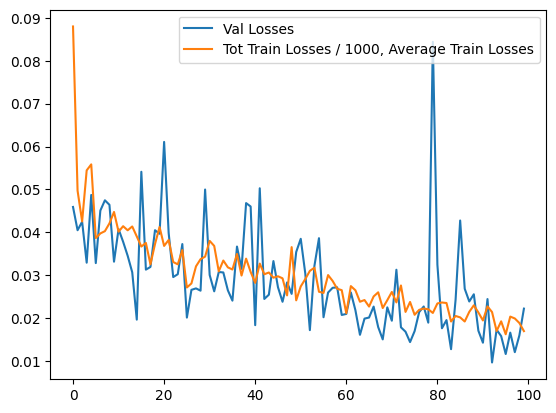

In [11]:
tot_train_losses = collector_dict['losses']['total_train'].numpy()/1000
val_losses = collector_dict['losses']['val'].numpy()

print(val_losses)
index = np.arange(100)

plt.plot(index, val_losses, label='Val Losses')
plt.plot(index, tot_train_losses, label= 'Tot Train Losses / 1000, Average Train Losses')
plt.legend()
plt.show()


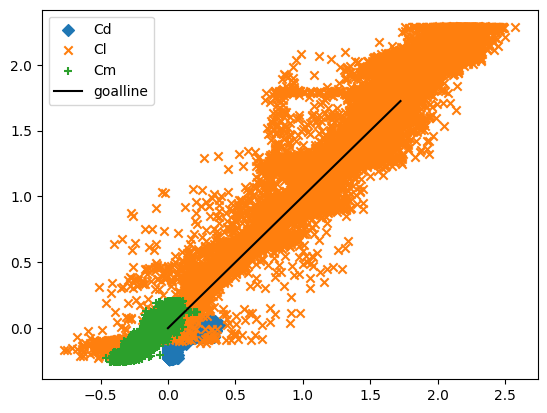

In [12]:
plt.scatter(collector_dict['actual']['test'][:,0].cpu().numpy(), collector_dict['preds']['test'][:,0].cpu().numpy(), marker='D', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,1].cpu().numpy(), collector_dict['preds']['test'][:,1].cpu().numpy(), marker='x', label= 'Cl')
plt.scatter(collector_dict['actual']['test'][:,2].cpu().numpy(), collector_dict['preds']['test'][:,2].cpu().numpy(), marker='+', label= 'Cm')
plt.plot(np.arange(17250)/10000, np.arange(17250)/10000, color='k', label='goalline')
plt.legend()
plt.show()


From this training, one can make the following conclusions:

- We have solved the major issue that was causing the model collapse: Scale of Reynolds #s
- MLP (with about 8 million less parameters) has better training and validation losses but interestingly the correlation plots are qualitatively more spread out?
- Next step, train way more MLPs, replicate the XFoil model params